# Breast Cancer Classification Using PCA and SVM Classifier

## Import Package

In [1]:
import warnings
warnings.simplefilter(action='ignore')

# linear algebra
import numpy as np

# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# pipeline & preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from jcopml.pipeline import num_pipe, cat_pipe
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from plotbasic import numeric_displot_all, outlier_boxplot_all, categoric_all, categoric_one

# model
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# report dan evaluasi
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value, plot_classification_report, plot_confusion_matrix,plot_roc_curve
from jcopml.feature_importance import mean_score_decrease, mean_loss_decrease
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score

#lime interpretation model
import lime
from lime import lime_tabular

#shap interpretation model
import shap
shap.initjs() 

#load model
from jcopml.utils import load_model

## Import Dataset

In [2]:
df = pd.read_csv("data/breast-cancer.csv", delimiter=';')
df.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,0
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,0
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,0
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,0
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,0


## Exploratory Data Analysis

### Missing Value

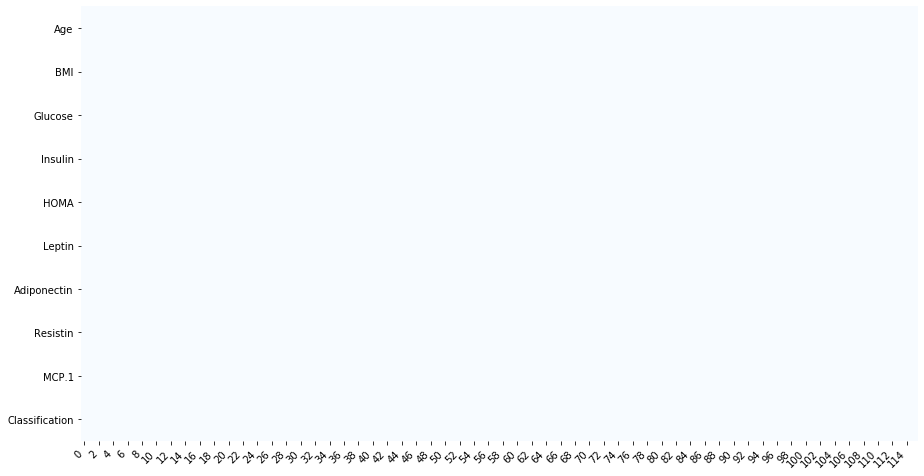

In [3]:
plot_missing_value(df)

### Classification

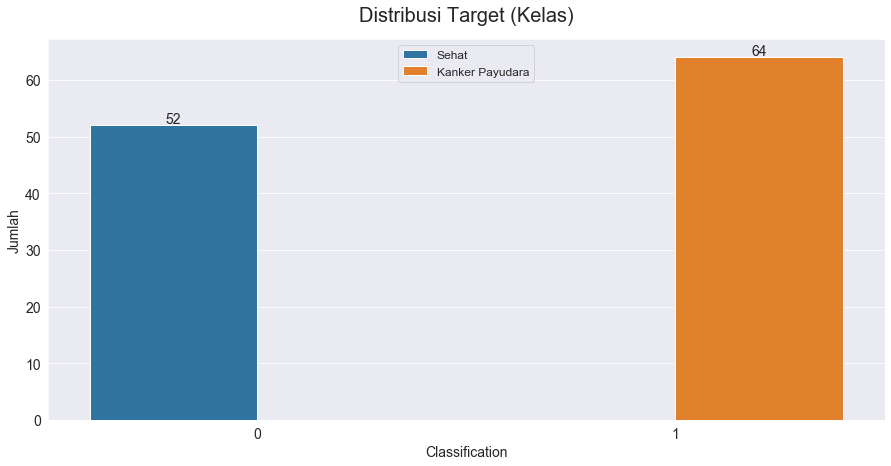

In [4]:
categoric_one(df, cols_name='Classification', target_name='Classification', label1='Sehat', label2='Kanker Payudara')

### Numeric

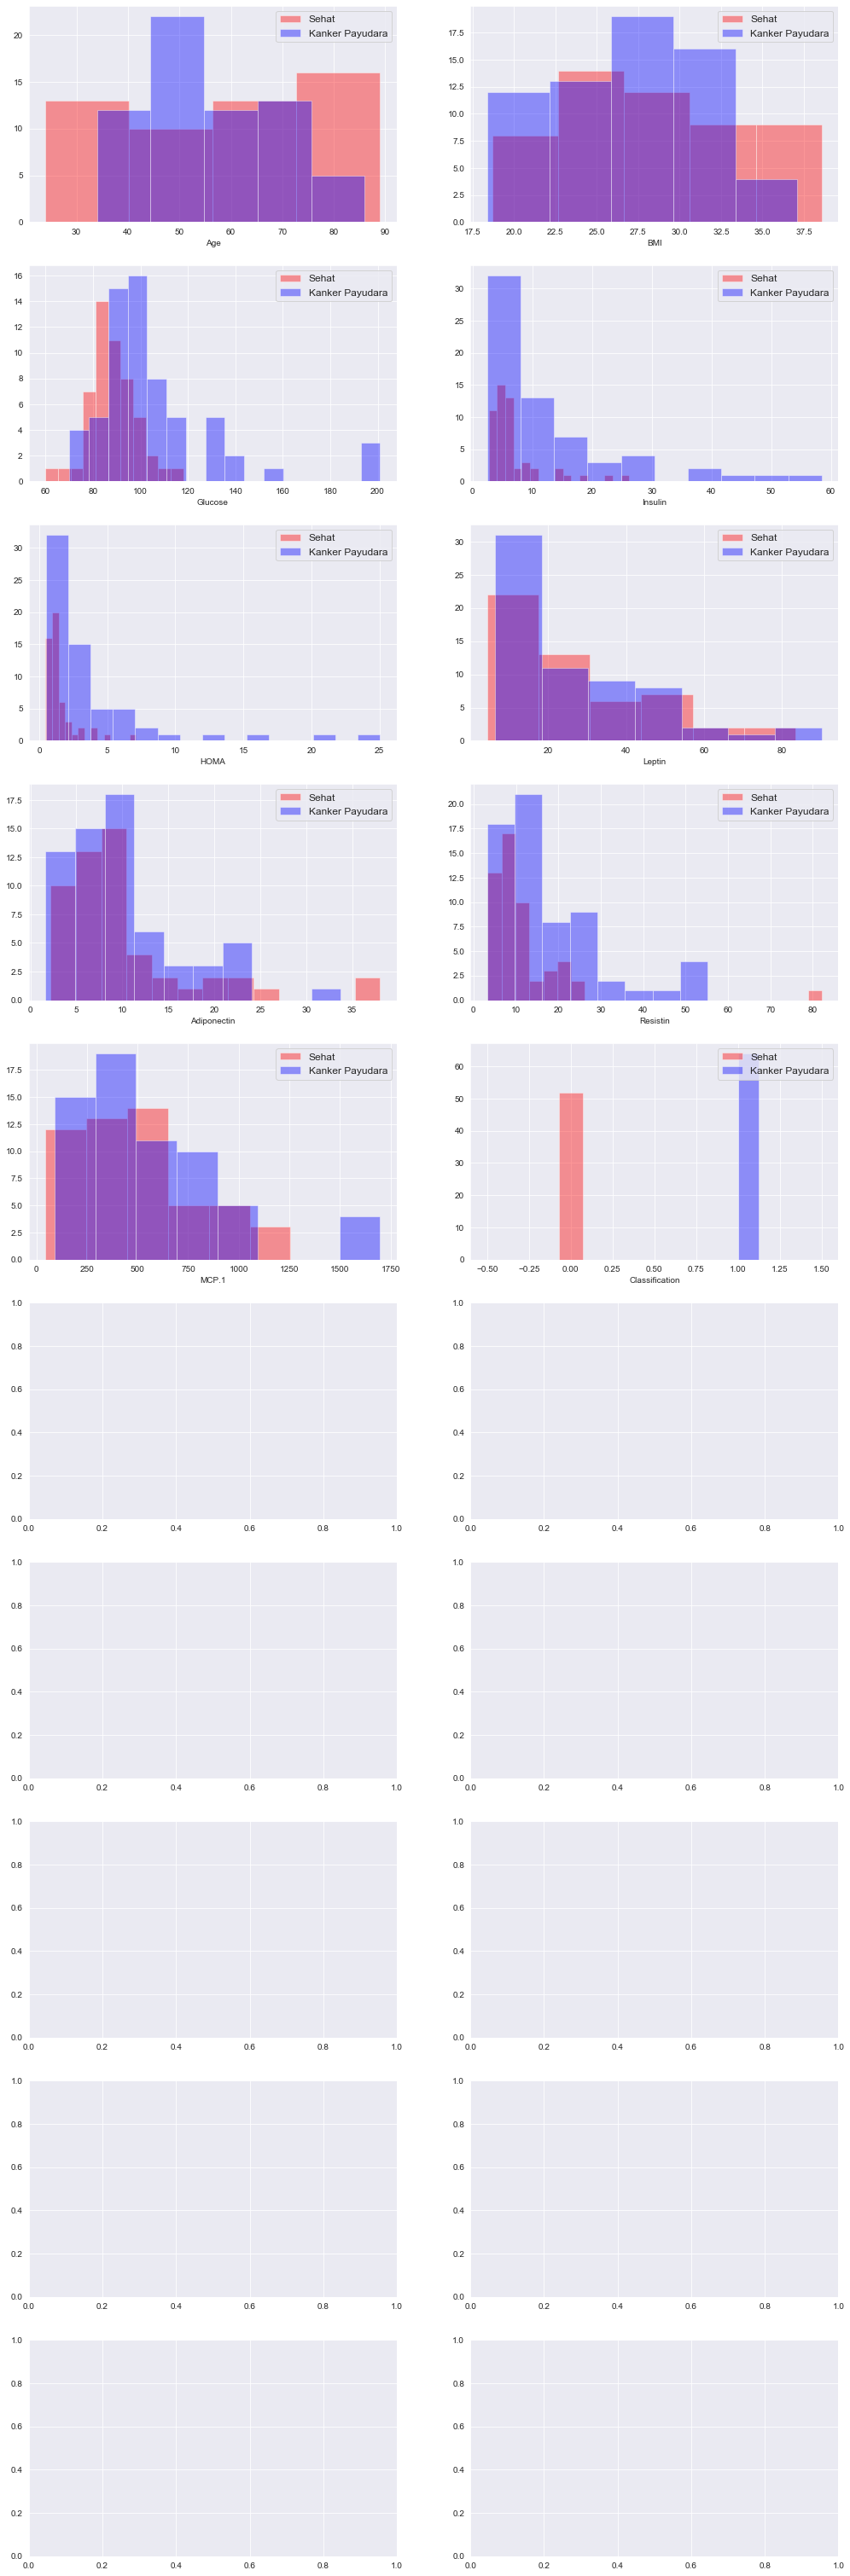

In [5]:
numeric_displot_all(df, target_name='Classification', bins=None, label1='Sehat', label2='Kanker Payudara')

## Dataset Splitting

In [6]:
X = df.drop(columns="Classification")
y = df.Classification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((92, 9), (24, 9), (92,), (24,))

## PCA (Principal Component Analysis)

In [7]:
pca = PCA(n_components=2, whiten=True)

X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

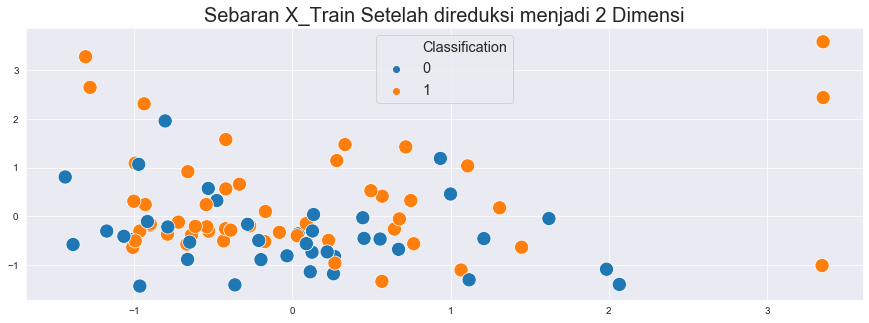

In [8]:
plt.figure(figsize=(15, 5))
sns.set_style(style="darkgrid")
sns.scatterplot(X_train_pca[:, 0], X_train_pca[:, 1], hue=y_train, s=200)
plt.legend(fontsize='x-large', title_fontsize='50', loc='upper center')
plt.title("Sebaran X_Train Setelah direduksi menjadi 2 Dimensi", fontsize=20);

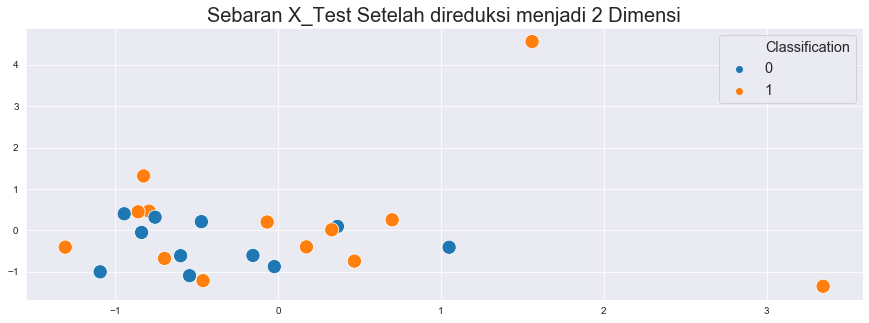

In [9]:
plt.figure(figsize=(15, 5))
sns.set_style(style="darkgrid")
sns.scatterplot(X_test_pca[:, 0], X_test_pca[:, 1], hue=y_test, s=200);
plt.legend(fontsize='x-large', title_fontsize='50', loc='upper right' )
plt.title("Sebaran X_Test Setelah direduksi menjadi 2 Dimensi", fontsize=20);

### Tune PCA Component

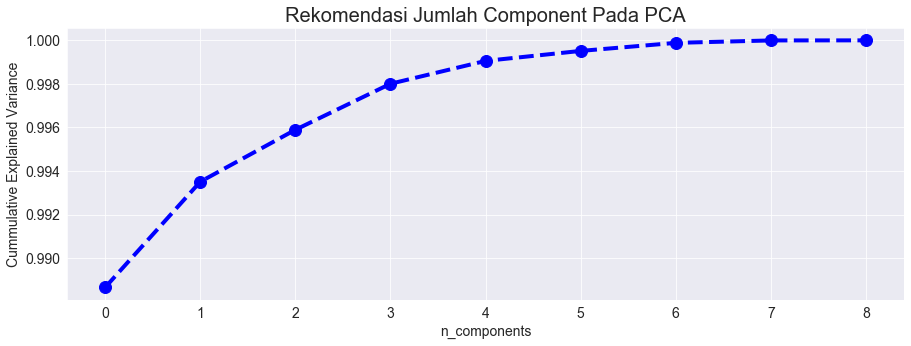

In [10]:
pca = PCA().fit(X_train)
plt.figure(figsize=(15, 5))
plt.plot(pca.explained_variance_ratio_.cumsum(), 'bo--', linewidth=4, markersize=12)
plt.xlabel("n_components", fontsize=14)
plt.ylabel("Cummulative Explained Variance", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Rekomendasi Jumlah Component Pada PCA", fontsize=20)
plt.show();

Dari rekomendasi hasil tune menggunakan PCA dan kita dapat melihat titik biru pada plot di atas, maka 
- Sumbu `X` menunjukkan ``n_components`` ==> Banyaknya component untuk mereduksi
- Sumbu `y` menunjukkan ``Cummulative Explained Variance`` ==> Sebearapa besar informasi dari data yang akan dipertahankan

- titik ``1`` akan mempertahankan informasi sebesar ``<=0.994``
- titik ``2`` akan mempertahankan informasi sebesar ``0.996``
- titik ``3`` akan mempertahankan informasi sebesar ``0.998``
- titik ``4`` akan mempertahankan informasi sebesar ``0.999``
- titik ``5`` akan mempertahankan informasi sebesar ``0.999``
- titik ``6 sampai 8`` akan mempertahankan informasi sebesar ``1.000``

Sehingga jumlah ``n_components`` yang akan dipakai adalah ``n_components = 3``, dan akan mereduksi dimensi yang sebelumnya berjumlah 9 dimensi menjadi 3 dimensi
    

## Training Model

### SVM and With Class Weight

ROC-AUC   :  0.881118881118881
Accuracy  :  0.8333333333333334
F1 Score  :  0.8461538461538461
Precision :  0.8461538461538461
Recall    :  0.8461538461538461


Train report
              precision    recall  f1-score   support

           0       0.68      0.78      0.73        41
           1       0.80      0.71      0.75        51

    accuracy                           0.74        92
   macro avg       0.74      0.74      0.74        92
weighted avg       0.75      0.74      0.74        92


Test report
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.85      0.85      0.85        13

    accuracy                           0.83        24
   macro avg       0.83      0.83      0.83        24
weighted avg       0.83      0.83      0.83        24

Model is pickled as model/breas-cancer.pkl


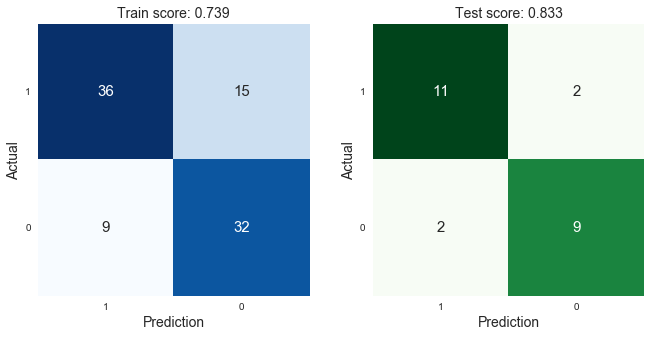

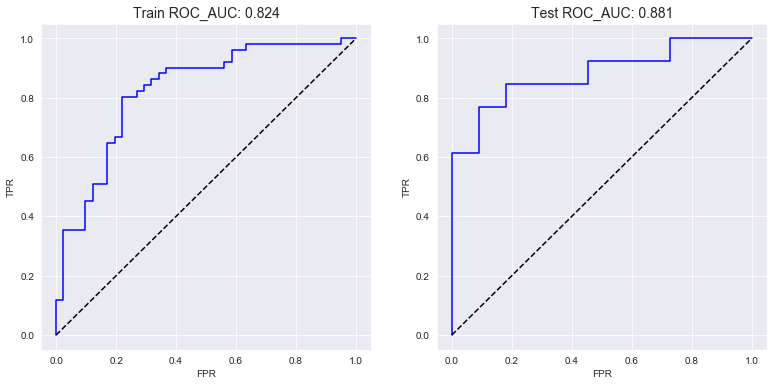

In [11]:
# preprocessing
preprocessor = ColumnTransformer([('numeric', num_pipe(scaling="minmax"), X_train.columns)])

#pipeline
svc = Pipeline([
    ('prep', preprocessor),
    ('pca',  PCA(n_components=3, whiten=True)),
    ('algo', SVC(random_state=42, max_iter=1000, class_weight='balanced', probability=True, gamma=0.01, C=100))
])

#model>>fit
svc.fit(X_train, y_train)

#testing
y_pred_proba = svc.predict_proba(X_test)[:,1] #probability kelas 2 >> kanker payudara [untuk kurva ROC]
y_pred       = svc.predict(X_test)

#report
print('ROC-AUC   : ', roc_auc_score(y_test, y_pred_proba))
print('Accuracy  : ', accuracy_score(y_test, y_pred))
print('F1 Score  : ', f1_score(y_test, y_pred))
print('Precision : ', precision_score(y_test, y_pred))
print('Recall    : ', recall_score(y_test, y_pred))
print('\n')

#classification report
plot_classification_report(X_train, y_train, X_test, y_test, svc, report=True)

#confusion matrix
plot_confusion_matrix(X_train, y_train, X_test, y_test, svc)

#roc-auc 
plot_roc_curve(X_train, y_train, X_test, y_test, svc)

#save model
save_model(svc, "breas-cancer.pkl")

## Save Model

In [12]:
save_model(svc, "breast-cancer.pkl")

Model is pickled as model/breast-cancer.pkl


## Interpretation Model Using Shap

### Explainer Shap

In [13]:
#ambil data array dari dataframe
def model_predict(data_asarray):
    data_asframe =  pd.DataFrame(data_asarray, columns=X_train.columns)
    return svc.predict_proba(data_asframe)

explainer = shap.KernelExplainer(model_predict, X_train, link='logit')
shap_values = explainer.shap_values(X_train.iloc[1,:])

### Single Prediction

Age             29.000000
BMI             32.270788
Glucose         84.000000
Insulin          5.810000
HOMA             1.203832
Leptin          45.619600
Adiponectin      6.209635
Resistin        24.603300
MCP.1          904.981000
Name: 22, dtype: float64

Data X_test ke- 4
Label/Probability Prediksi 0: 0.6895544196582691
Label/Probability Prediksi 1: 0.3104455803417309
Label asli     :  0


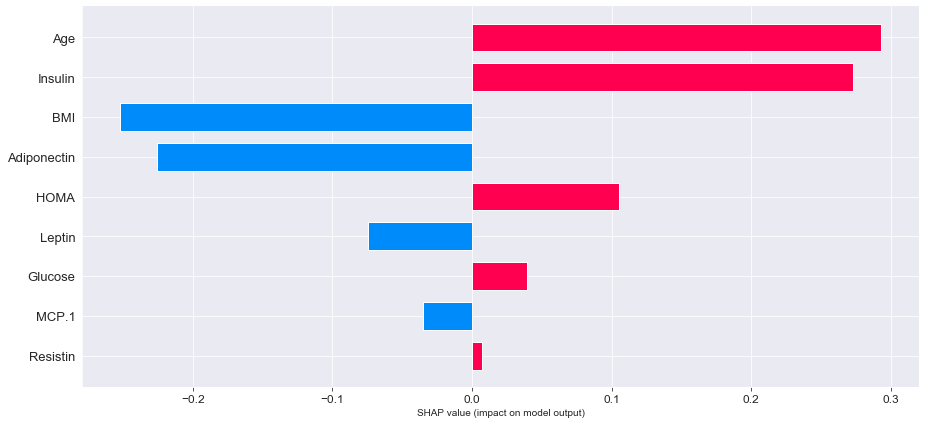

In [24]:
# i = 189
i = np.random.randint(0, 23)
observation = X_test.iloc[[i], :]

print(X_test.iloc[i])
print("\nData X_test ke-",i)
print("Label/Probability Prediksi 0:",svc.predict_proba(observation)[:,0].item())
print("Label/Probability Prediksi 1:",svc.predict_proba(observation)[:,1].item())
print("Label asli     : ",y_test.iloc[i])

#plot
plt.figure(figsize=(15,7), facecolor='w')
plt.xticks(fontsize=12);plt.yticks(fontsize=12)

#bar plot
shap.bar_plot(shap_values[0], max_display=10, show=False, feature_names=X_train.columns)

#force plot
shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=X_train.columns, link='logit')

### Feature Importance

In [15]:
#ambil data array dari dataframe
def model_predict(data_asarray):
    data_asframe =  pd.DataFrame(data_asarray, columns=X_train.columns)
    return svc.predict_proba(data_asframe)

explainer_summary   = shap.KernelExplainer(model_predict, X_train, link='logit')
shap_values_summary = explainer_summary.shap_values(X_train)

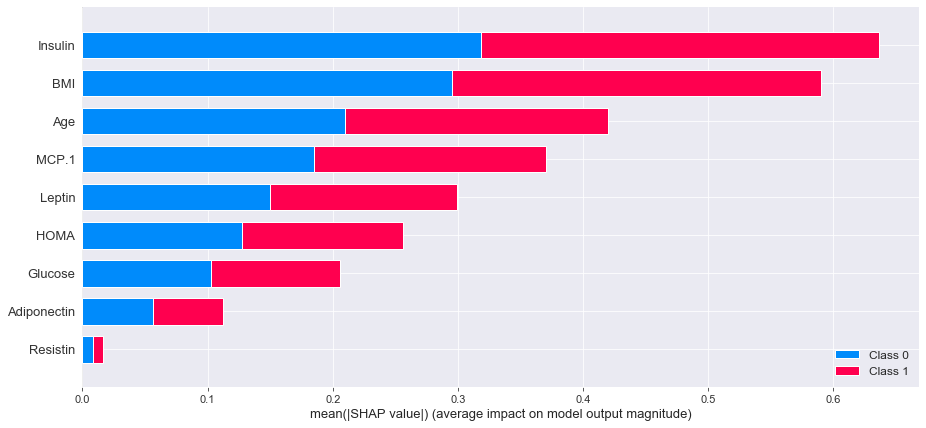

In [16]:
plt.figure(figsize=(15,7), facecolor='w')
shap.summary_plot(shap_values_summary, observation, plot_type="bar",feature_names=X_train.columns, max_display=9, show=True, plot_size=None)